# <Center> Homework 5: Classification </center>

This assignment needs the following two data files:
- train.csv: dataset for training
- test.csv: dataset for testing. 
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  I must admit that I'm addicted to "Version 2.0...|
|0|  I think it's such a shame that an enormous tal...|
|1|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|


## Q1 Classification

- Define a function `create_model(train_docs, train_y, test_docs, test_y, model_type='svm', stop_words='english', min_df = 1, print_result = True, algorithm_para=1.0`), where

    - `train_docs`: is a list of documents for training
    - `train_y`: is the ground-truth labels of training documents
    - `test_docs`: is a list of documents for test
    - `test_y`: is the ground-truth labels of test documents
    - `model_type`: two options: `nb` (Multinomial Naive Bayes) or `svm` (Linear SVM)
    - `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
    - `min_df`: only word with document frequency above this threshold can be included. The default is 1. 
    - `print_result`: controls whether to show classification report or plots. The default is True.
    - `algorithm_para`: the hyperparameter of algorithms, refers to C in SVM and alpha in NB. Both C and alpha have default values of 1.0. Please check sklearn documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


- This function does the following:
    - Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Build `linear SVM` or `Multinomial Naive Bayes` model as specified by `model_type` with `algorithm_para` setting. Train the model using the extracted features and `train_y`. 
    - Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
    - Predict the labels for `test_docs`. If `print_result` is True, print the classification report.
    - Calculate the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. If `print_result` is True, plot the ROC and PRC curves. **Hint**: 
        - `sklearn.svm.LinearSVM` does not provide `predict_proba` function. 
        - Instead, you can use its `decision_function` (see <a href = "https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s">some referenc code</a>) 
        - Another option is to use `sklearn.svm.SVC` with `kernel='linear' and probability=False` (see <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html"> reference</a>)
    - Return the AUC and PRC scores.

    
- Test your function with following cases:
    - model_type='svm', stop_words = 'english', min_df = 1
    - model_type='nb', stop_words = 'english', min_df = 1

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords

train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")


In [2]:
# Define the function for Task 1

def create_model(train_docs, train_y, test_docs, test_y, \
              model_type='svm', stop_words=None, min_df = 1, print_result = True, algorithm_para=1.0):
    
    
    # if stop_words:
    #     stop_words = stopwords.words(stop_words)
    #     stop_words.remove('not')    
    
    tfIdf = TfidfVectorizer(stop_words=stop_words, min_df=min_df)
    train_x = tfIdf.fit_transform(train_docs)
    test_x = tfIdf.transform(test_docs)
    
    if model_type == 'nb':
        classifier = MultinomialNB(alpha = algorithm_para)
    elif model_type == 'svm':
        classifier = svm.LinearSVC(C = algorithm_para)
    else:
        raise Exception('Invalid Model Type has been provided')
    

    classifier.fit(train_x, train_y)
    
    pred_y = classifier.predict(test_x)
    
    prob_y = classifier.predict_proba(test_x)[:,1] if model_type=='nb' else classifier.decision_function(test_x)
    

    
    fpr, tpr, _ = roc_curve(test_y, prob_y, pos_label=1)
    pr, re, _ = precision_recall_curve(test_y, prob_y, pos_label=1)
    precision, recall, _, _= precision_recall_fscore_support(test_y, pred_y)
    
    if print_result:
        print(classification_report(test_y, pred_y))
        print("AUC: %.2f%% PRC: %.2f%%"%(auc(fpr, tpr)*100, auc(re,pr)*100))
        
        plt.figure(figsize=(50,30))
        
        fig1 = plt.subplot(8,8,1)
        fig1.plot(fpr, tpr, color='darkorange')
        fig1.plot([0, 1], [0, 1], color='navy', linestyle='--')
        fig1.set_xlim([0,1])
        fig1.set_ylim([0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('%s-AUC'%model_type)

        fig2 = plt.subplot(8,8,2)
        fig2.plot(re, pr, color='darkorange')
        fig2.set_xlim([0,1])
        fig2.set_ylim([0,1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('%s-PRC'%model_type)

        plt.show()
    
    return auc(fpr, tpr)*100, auc(re,pr)*100

    

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       509
           1       0.82      0.84      0.83       491

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000

AUC: 91.50% PRC: 91.59%


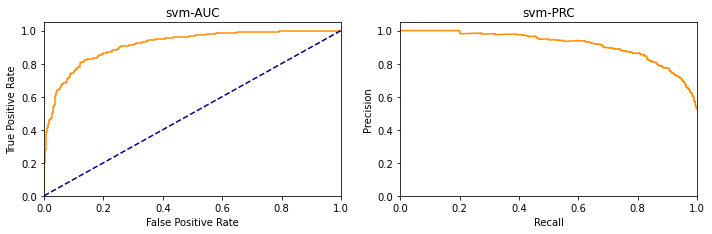

(91.50084627419282, 91.59269977052087)

In [3]:
create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       509
           1       0.82      0.84      0.83       491

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000

AUC: 91.50% PRC: 91.59%


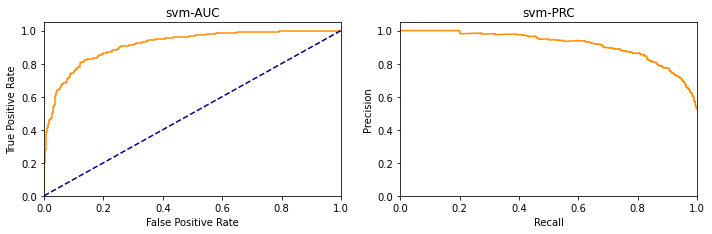

In [4]:
# Test the function with 'svm'

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       509
           1       0.78      0.83      0.80       491

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

AUC: 88.87% PRC: 89.49%


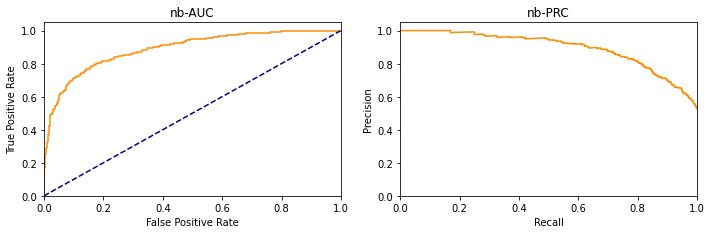

In [5]:
# Test the function with 'nb' 

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
                    model_type='nb', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

### Task 2: Search for best parameters 

From Task 1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier 
    - Define the parameter ranges as follow:
        - `stop_words': [None, 'english']`
        - `min_df: [1,2,5]`
        - `C: [0.2,0.5,0.8]`
    - Set the scoring metric to "f1_macro"
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the best parameter values
    
- Call the function `svm_model` defined in Task 1 `with the best parameter values`. You will have to add the best C value to the original function, because you used default settings of the SVM classifier previously. Then please briefly answer the following:
    - Compare with the model in Task 1, how is the performance improved on the test dataset?
    - Why do you think the new parameter values help sentiment classification?

In [6]:
# Define grade search function

def search_para(docs, y):
    pipe = Pipeline([('vectorizer',TfidfVectorizer()), ('svc', svm.LinearSVC())])

    stopWords = stopwords.words('english')
    stopWords.remove('not')

    gridValues = {
        "vectorizer__stop_words": [None, 'english'],
        "vectorizer__min_df": [1, 2, 5],
        "svc__C": [0.2, 0.4, 0.8]
    }
    clf = GridSearchCV(pipe, param_grid=gridValues, scoring='f1_macro', cv=5)
    clf.fit(docs, y)

    return clf
    # Add your code here


In [7]:
clf = search_para(train["text"], train["label"])
clf.best_estimator_

Pipeline(steps=[('vectorizer', TfidfVectorizer(min_df=2)),
                ('svc', LinearSVC(C=0.4))])

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       509
           1       0.85      0.84      0.84       491

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

AUC: 92.35% PRC: 92.08%


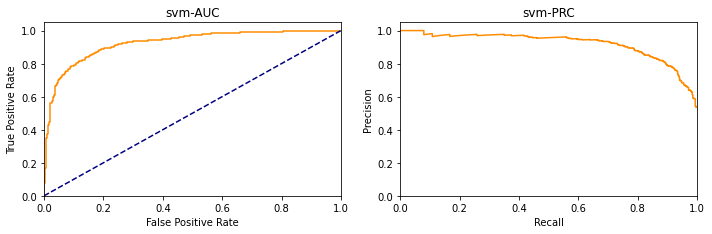

In [8]:
# call the function with the best parameters

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = None, min_df = 2, print_result=True, algorithm_para=0.4)

# Please answer the questions


              precision    recall  f1-score   support

           0       0.84      0.86      0.85       509
           1       0.85      0.84      0.84       491

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

AUC: 92.42% PRC: 92.30%


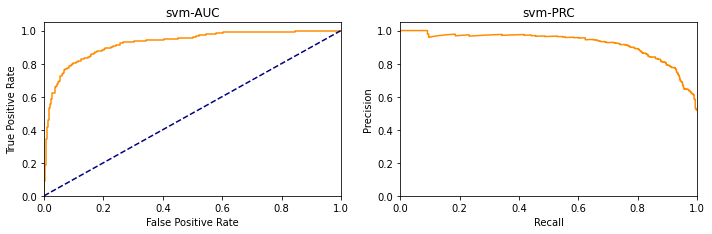

In [9]:
# call the function with the best parameters

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = None, min_df = 2, print_result=True, algorithm_para=0.2)

# Please answer the questions


## Task 3. How many samples are enough? 

This task is to help you understand the impact of sample size on classifier performance. 

- Define a function `sample_size_impact(train_docs, train_y, test_docs, test_y)` with the input as defined above. 
    
    
- This function does the following:
    - Starting with 500 samples, in each round you build a classifier with 500 more samples. i.e. in round 1, you use samples from 0:500, and in round 2, you use samples from 0:1000, …, until you use all samples. 
    - In each round, call the `create_model` function with `model_type='svm'` and then `model_type='nb'`. Keep other parameters as default. Record the AUC score of each model type and the sample size.
    - For each model type, plot a line chart show the relationship between sample size and the AUC score. 
    - This function has no return.
    
    
- Write your analysis on the following:
    - How sample size affects each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
    - How is performance of SVM classifier compared with Naïve Bayes classifier?

In [10]:
# Show the impact of sample size

def sample_size_impact(train_docs, train_y, test_docs, test_y):  
    
    counter = 500
    xValues = []
    ynbValues = []
    ysvmValues =[]
    while counter<= len(train_docs):
        xValues.append(counter)
        nb_auc_score, _ = create_model(train_docs[:counter], train_y[:counter], test_docs, test_y, \
                    model_type='nb', stop_words = 'english', min_df = 1, print_result=False, algorithm_para=1.0)
        svm_auc_score, _ = create_model(train_docs[:counter], train_y[:counter], test_docs, test_y, \
                    model_type='svm', stop_words = 'english', min_df = 1, print_result=False, algorithm_para=1.0)
        ynbValues.append(nb_auc_score)
        ysvmValues.append(svm_auc_score)
        counter += 500

    plt.plot(xValues, ysvmValues, label='SVM', color='darkorange')
    plt.plot(xValues, ynbValues, label='NB', color='navy')
    plt.legend(loc='best')
    plt.show()

    # add your code here

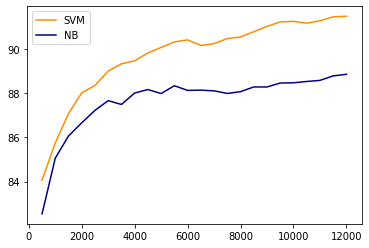

In [11]:
# Test the function

sample_size_impact(train["text"], train["label"], test["text"], test["label"])

# Briefly answer the questions

## Task 4 (Bonus): How to improve sentiment classification?

- Can you tune other parameters of TfidfVectorizer or SVM model to further improve the classification performance? Try to beat the model you get in Task 2!

In [12]:
 # add your code here